# The Machinery

For proof of concept, I consider Gaussian generative models with MLP discriminator. The Gaussian generative models take data from n-dimensional latent space $z \sim \mathcal{N}(0, I)$ to arbitrary n-dimensional $\mathcal{N}(\mu, \Sigma)$ by learned affine transformation.

In [1]:
import numpy as np
import theano as theano
import theano.tensor as T

ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/hudson/.local/lib/python3.5/site-packages/theano/gpuarray/__init__.py", line 166, in <module>
    use(config.device)
  File "/home/hudson/.local/lib/python3.5/site-packages/theano/gpuarray/__init__.py", line 153, in use
    init_dev(device)
  File "/home/hudson/.local/lib/python3.5/site-packages/theano/gpuarray/__init__.py", line 60, in init_dev
    sched=config.gpuarray.sched)
  File "pygpu/gpuarray.pyx", line 614, in pygpu.gpuarray.init (pygpu/gpuarray.c:9419)
  File "pygpu/gpuarray.pyx", line 566, in pygpu.gpuarray.pygpu_init (pygpu/gpuarray.c:9110)
  File "pygpu/gpuarray.pyx", line 1021, in pygpu.gpuarray.GpuContext.__cinit__ (pygpu/gpuarray.c:13472)
pygpu.gpuarray.GpuArrayException: Error loading library: 0


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append('/home/hudson/Projects/GAMM')
from lib.utils import log_progress

## Generator

In [4]:
class GaussianGenerator(object):
    def __init__(self, input, ndim= 1, mu=None, sig=None, scale=1):
        if mu is None:
            mu = scale*np.random.randn(ndim,).astype(theano.config.floatX)
        mu = theano.shared(value=mu, name='mu', borrow=True)
        if sig is None:
            sig = np.random.randn(ndim, ndim).astype(theano.config.floatX)
        sig = theano.shared(value=sig, name='sigma', borrow=True)
        self.mu = mu
        self.sig = sig
        
        ndim = mu.shape[0].eval()
        self.ndim = ndim
        
        self.params = [self.mu, self.sig]
        
        self.out = (T.dot(self.sig, input).T + self.mu.T)
        
    def sample(self, n=1):
        z = np.random.randn(self.ndim, n).astype(theano.config.floatX)
        out = (T.dot(self.sig, z).T + self.mu.T)
        return(out)

## Discriminator

In [5]:
class Hidden(object):
    #http://deeplearning.net/tutorial/mlp.html
    def __init__(self, input, n_in, n_out, W = None, b = None,
                 activation = T.tanh, rng = np.random.RandomState()):
        
        self.input = input
        
        if W is None:
            W_range = np.sqrt(6. / (n_in + n_out))
            W_values = np.asarray(
                rng.uniform(
                    low = -W_range,
                    high = W_range,
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == T.nnet.sigmoid:
                W_values *= 4
            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b
        
        # parameters of the model
        self.params = [self.W, self.b]
        
        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )

In [6]:
class LogisticRegression(object):
    def __init__(self, input, n_in, n_out, W = None, b = None,
                 rng = np.random.RandomState()):
        self.input = input
        
        if W is None:
            W_range = np.sqrt(6. / (n_in + n_out))
            W_values = np.asarray(
                rng.uniform(
                    low = -W_range,
                    high = W_range,
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b
        
        self.params = [self.W, self.b]
        
        self.lin = T.dot(input, self.W) + b
        
        self.p_y = T.nnet.softmax(T.dot(input, self.W) + b)
            
        self.y_pred = T.argmax(self.p_y, axis=1)

In [7]:
class MLP(object):
    def __init__(self, input, n_in, n_out, n_hidden=300, params = None,
                 rng = np.random.RandomState()):
        self.input = input
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.rng = rng
        
        hidden = Hidden(
            input,
            n_in, n_hidden,
            W = None if params is None else params[0],
            b = None if params is None else params[1],
            rng = rng
        )
        self.hidden = hidden
        
        out = LogisticRegression(
            self.hidden.output,
            n_hidden, n_out,
            W = None if params is None else params[2],
            b = None if params is None else params[3],
            rng = rng
        )
        self.out = out
        
        self.lin = out.lin
        self.p_y = out.p_y
        self.y_pred = out.y_pred
        
        self.params = hidden.params + out.params
        
    def predict(self, x):
        mlp = MLP(x, self.n_in, self.n_out, self.n_hidden, self.params, self.rng)
        return(mlp.y_pred.eval())

##### Distribution to fit. Mixture of Gaussians

In [22]:
z = T.matrix('z')
n = 10000
mixture = np.array([1, 1, 1])
mixture = mixture/sum(mixture)
x = []
for proportion in mixture:
    g = GaussianGenerator(z,ndim=2, scale = 2*len(mixture)**2)
    z = g.sample(int(proportion * n)).eval()
    x.append(z)
x = np.vstack(x).astype('float32')

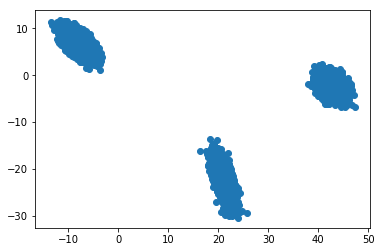

In [23]:
plt.scatter(x[:,0], x[:,1])

### Model fitting

In [10]:
def decision(X, model, h=.05):
    # X - some data in 2dimensional np.array
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # here "model" is your model's prediction (classification) function
    Z = model(np.c_[xx.ravel(), yy.ravel()]) 

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    #plt.axis('off')
    
def plotDecision(X, gens, crit):
    gX = []
    gY = []
    for i in range(len(gens)):
        g = gens[i]
        z = g.sample(n).eval()
        gX.append(z)
    gX = np.vstack(gX)

    plt.figure()
    decision(np.vstack((X, gX)), crit.predict)
    plt.scatter(X[:,0], X[:,1])
    plt.scatter(gX[:,0], gX[:,1])
    plt.show()

In [31]:
def Adam(cost, params, lr=0.0002, b1=0.9, b2=0.999, e=1e-8, c=None):
    #https://gist.github.com/Newmu/acb738767acb4788bac3
    #Standard literature says b1=.9
    #DCGAN paper says b1 = .5
    b1 = 1-b1
    b2 = 1-b2
    updates = []
    grads = T.grad(cost, params)
    i = theano.shared(np.float32(0.))
    i_t = i + 1.
    fix1 = 1. - (1. - b1)**i_t
    fix2 = 1. - (1. - b2)**i_t
    lr_t = lr * (T.sqrt(fix2) / fix1)
    for p, g in zip(params, grads):
        m = theano.shared(p.get_value() * 0.)
        v = theano.shared(p.get_value() * 0.)
        m_t = (b1 * g) + ((1. - b1) * m)
        v_t = (b2 * T.sqr(g)) + ((1. - b2) * v)
        g_t = m_t / (T.sqrt(v_t) + e)
        p_t = p - (lr_t * g_t) if c is None else T.clip(p - (lr_t * g_t), -c, c)
        updates.append((m, m_t))
        updates.append((v, v_t))
        updates.append((p, p_t))
    updates.append((i, i_t))
    return updates

def RMSprop(cost, params, lr=0.00005, rho=0.99, epsilon=1e-8, c=None):
    #https://github.com/Newmu/Theano-Tutorials
    #rho = .99 is torch default, used in paper
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        update = p - lr * g if c is None else T.clip(p - lr * g, -c, c)
        updates.append((p, update))
    return updates

def gradDesc(cost, params, lr=.00005, c = None):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        update = p - lr * g if c is None else T.clip(p - lr * g, -c, c)
        updates.append((p, update))
    return updates

In [37]:
def train(X, n_hidden = 500,
         batch_size = 100, iters = 400, alpha = .0005,
         rng = np.random.RandomState()):
    
    x = T.matrix('x')
    z = T.matrix('z')

    ndim = X.shape[1]    
    
    print("Building model...")
    ################### Generator ###################
    
    gen = GaussianGenerator(z, ndim=ndim, scale = 50)
    genParams = gen.params
    genCrit = MLP(gen.out, ndim, 2, n_hidden = n_hidden)
    critParams = genCrit.params
    realCrit = MLP(x, ndim, 2, n_hidden = n_hidden, params = critParams)

    critLoss = -T.mean(T.log(realCrit.p_y[:,0])) \
                -T.mean(T.log(genCrit.p_y[:,1]))
    
    genLoss = T.mean(T.log(genCrit.p_y[:,1]))
    
    critUpdates = Adam(critLoss, critParams, lr=alpha)
    genUpdates = Adam(genLoss, genParams, lr=alpha)
    
    trainGen = theano.function(
        inputs = [], 
        outputs = genLoss, 
        updates = genUpdates,
        givens = {z: np.random.randn(X.shape[1], batch_size)
                                  .astype(theano.config.floatX)
                 }
    )
        
    trainCrit = theano.function(
        inputs = [x], 
        outputs = critLoss, 
        updates = critUpdates,
        givens = {z: np.random.randn(X.shape[1], batch_size)
                                  .astype(theano.config.floatX)
                 }
    )
        
    #################################################
    print("Done!")
    
    print('Begin training...')
    
    mixPlot = []
    critPlot = []
    for iter in log_progress(range(iters), every=100):
        if iter % 5000 == 0:
            if iter != 0:
                plt.figure()
                plt.plot(critPlot)
                plt.title("Generator Critic Losses")
                plt.show()
            
            plt.figure()
            gx = gen.sample(1000).eval()
            plt.scatter(X[:,0], X[:,1])
            plt.scatter(gx[:,0], gx[:,1])
            plt.show()
        #gen/crit
        iterCrit = []
        xG = X[rng.randint(X.shape[0], size=batch_size)]
        iterCrit.append(-trainCrit(xG))
        trainGen()
        critPlot.append(iterCrit)
        
    #Final Plot
    plt.figure()
    plt.plot(critPlot)
    plt.title("Generator Critic Losses")
    plt.show()

    plt.figure()
    gx = gen.sample(1000).eval()
    plt.scatter(X[:,0], X[:,1])
    plt.scatter(gx[:,0], gx[:,1])
    plt.show()
    
    return(gen)

Building model...
Done!
Begin training...


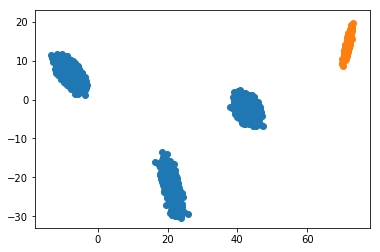

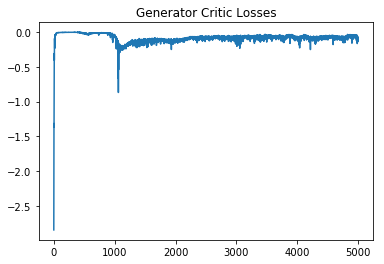

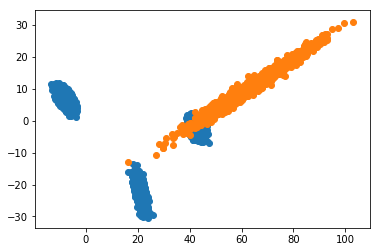

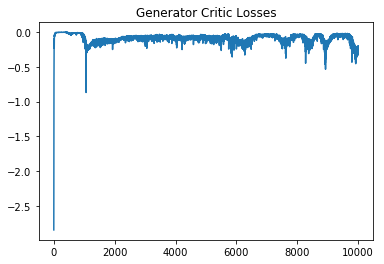

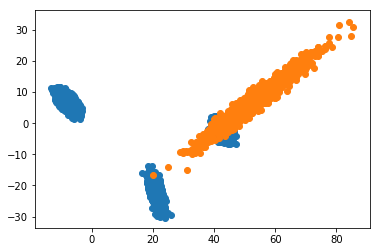

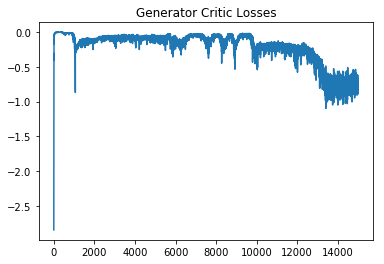

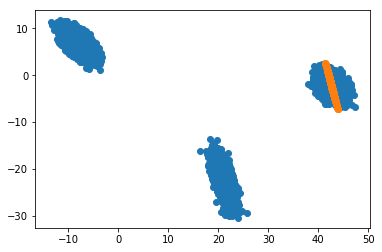

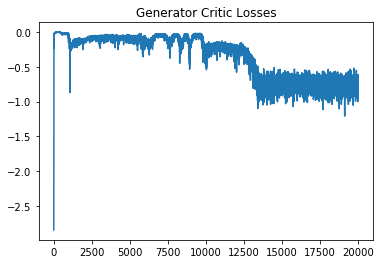

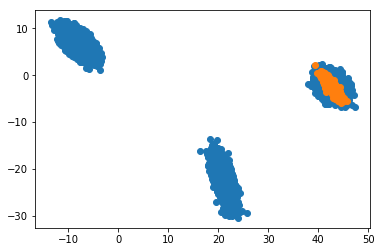

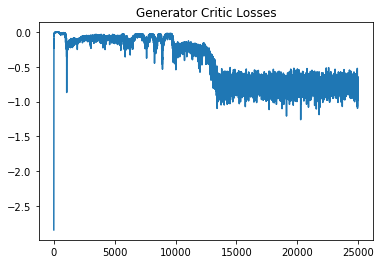

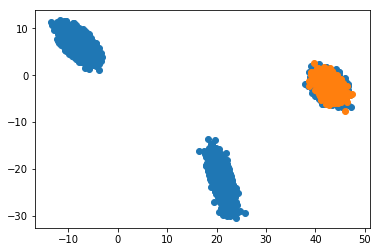

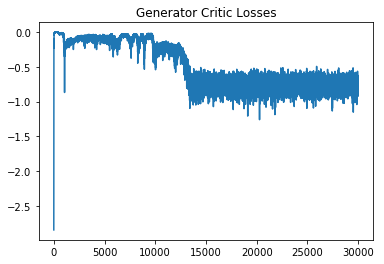

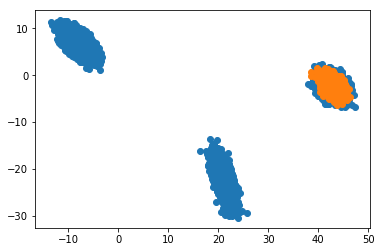

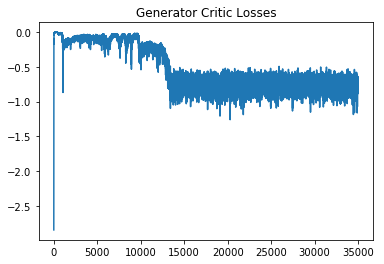

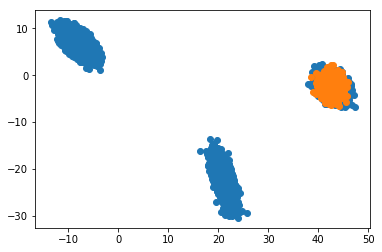

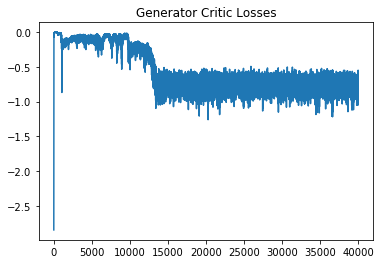

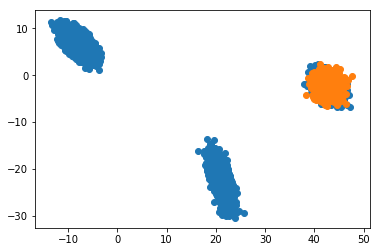

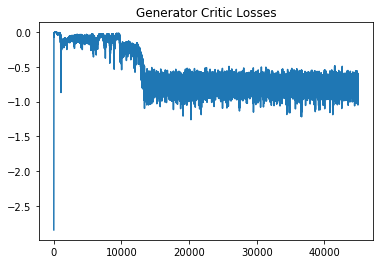

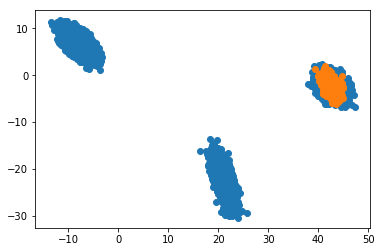

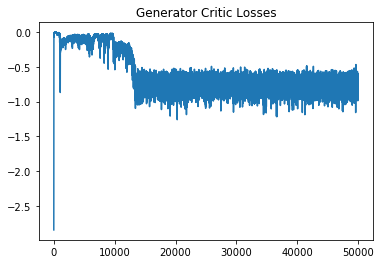

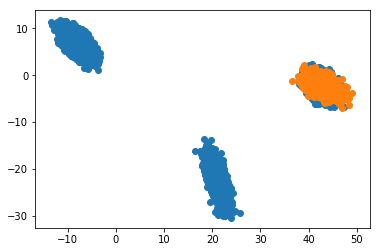

In [38]:
gen = train(x, n_hidden = 500, batch_size = 100, iters = 50000, alpha = .005)